In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set()
%matplotlib inline

# 0. Тизер о распределении p-value

In [4]:
from scipy.stats import norm

In [5]:
sigma = 1.
mu = 0.0
N = 1000

In [6]:
[1 - norm(loc=0., scale=sigma / np.sqrt(N)).cdf(mu + np.random.randn(N).mean()) for _ in range(1000)]

[0.0556561914407353,
 0.359297135817908,
 0.5056034856633314,
 0.290086702720175,
 0.4535620924912446,
 0.2202769099923445,
 0.7533195210497696,
 0.30470283022008027,
 0.04112889830690236,
 0.5878083148206816,
 0.5075778279164664,
 0.956493176259345,
 0.9698234581317973,
 0.5307913327728355,
 0.4940078809795364,
 0.6411031839858253,
 0.51087949977329,
 0.7791192989276299,
 0.8278056402357256,
 0.94953173919843,
 0.4947661983003634,
 0.8008337388494483,
 0.6050958090305627,
 0.920545907181804,
 0.15344331009678036,
 0.12440421560288728,
 0.7242518387754026,
 0.8939825562371604,
 0.9624779518864935,
 0.18784015269329757,
 0.8012663771383111,
 0.04867687373074214,
 0.5098532912074591,
 0.009791341582947366,
 0.7633326035863097,
 0.014087683147846364,
 0.6431819061361429,
 0.9356352011800998,
 0.3059803368319267,
 0.7441268554835032,
 0.5785363621292936,
 0.7919800488242554,
 0.12934033285269175,
 0.06471229158616376,
 0.8612323258169905,
 0.7883972522735674,
 0.9234675980685518,
 0.795724

(array([ 99.,  90., 107., 106., 107.,  98., 100.,  97.,  87., 109.]),
 array([9.25398991e-04, 1.00773532e-01, 2.00621665e-01, 3.00469798e-01,
        4.00317932e-01, 5.00166065e-01, 6.00014198e-01, 6.99862331e-01,
        7.99710464e-01, 8.99558597e-01, 9.99406730e-01]),
 <BarContainer object of 10 artists>)

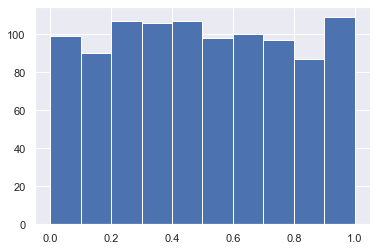

In [7]:
plt.hist([1 - norm(loc=0., scale=sigma / np.sqrt(N)).cdf(mu + np.random.randn(N).mean()) for _ in range(1000)])

$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

# 1. Коррекция Бонферрони
(Адаптировано из https://matthew-brett.github.io/teaching/bonferroni_correction.html)


Коррекция Бонферрони задаёт уровень отсечения по p-value так чтобы вероятность *хотя бы раз* совершить ошибку I рода была не больше заранее заданной величины. 

### Family-wise error

Мы пытаемся найти $\theta$ -- threshold (уровень отсечения), что $p(\mathrm{p-value}_i < \theta) = \alpha, \forall \mathrm{p-value_i} \in \{ \mathrm{p-value_i} \}_{i=1}^{n}$

### Коррекция Сидака

Начнём с более простой коррекции для объяснения -- коррекция Сидака.

Вероятность что для всех $n$ тестов p-value *больше* уровня отсечения $\theta$, *в предположении независимости тестов*:

$$
P(\textrm{p-value}_i > \theta, \forall i) = (1 - \theta)^n
$$

Тогда шанс, что хотя бы для одного p-value верно $\mathrm{p-value} \le \theta$:

$$
P(\exists i: \textrm{p-value}_i > \theta) = 1 - (1 - \theta)^n
$$

Зададим групповую вероятность ошибки I первого рода (FWER):

$$
\alpha_{fwe} = 1 - (1 - \theta)^n
$$

И найдём $\theta$:

$$
\theta = 1 - (1 - \alpha_{fwe})^{1 / n}
$$

Например, для $\alpha_{fwe} = 0.05$:

In [10]:
def sidak_thresh(alpha_fwe, n):
    return 1 - (1 - alpha_fwe)**(1./n)

print(sidak_thresh(0.05, 100))

0.0005128014162623096


# Коррекция Бонферрони

Коррекция Бонферрони использует неравенство Буля, которое утверждает что вероятность хотя бы одного события не больше чем сумма вероятностей всех индивидуальных событий:

$$
\mathrm{P} \biggl(\bigcup_{i} A_i\biggr) \le \sum_i {\mathbb P}(A_i),
$$

что очевидно следует из диаграмм Виета.

Тогда можно ввести следующую коррекцию:

$$
\frac{\alpha_{fwe}}{n} \le \theta
$$

Например, для $\alpha_{fwe} = 0.05$ и $n=10$:

In [12]:
def bonferroni_thresh(alpha_fwe, n):
    return alpha_fwe / n

print(bonferroni_thresh(0.05, 100))

0.0005


*Коррекция Бонферрони не использует предположения о независимости тестов*

Это означает что коррекция Бонферрони более консервативная (строгая) когда предположение о независимости не выполняется.

Коррекция Бонферрони
$\theta_{Bonferroni} = \alpha_{fwe} \space / \space n$ всегда строже Спивака $\theta_{Šidák}$ для $n \ge 1$, но всё же близка:

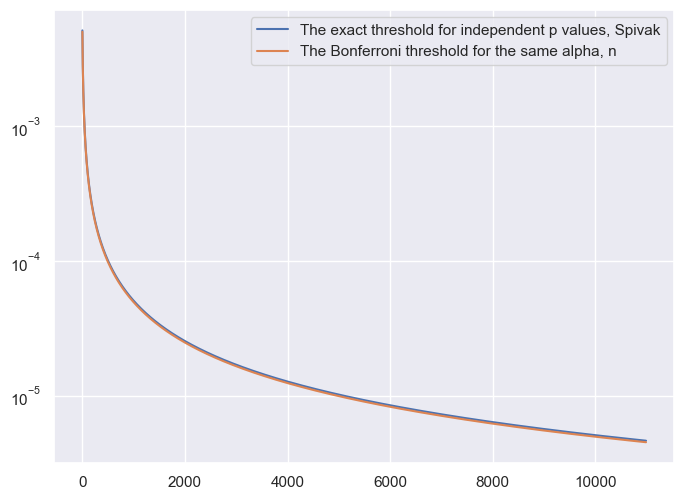

In [13]:
n_tests = np.arange(10, 11000)  # n = 1 through 10

plt.figure(figsize=(8, 6), dpi=100)
plt.plot(sidak_thresh(0.05, n_tests), label="The exact threshold for independent p values, Spivak")
plt.plot(bonferroni_thresh(0.05, n_tests), label="The Bonferroni threshold for the same alpha, n")
plt.yscale('log')
plt.legend()
plt.show()

$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

# 2. FDR
(Адаптировано из https://matthew-brett.github.io/teaching/fdr.html)


FDR (ожидаемая доля ложных отклонений) альтернативный вариант выбора уровня отсечения.

В методе FDR мы фиксируем *матожидание числа ошибок первого рода*, т.е.:

$$
E(\mathrm{False Positive}) \leq N \alpha 
$$


Давайте посмотрим на пример:

In [14]:
N = 100
z_values = np.random.normal(size=N)

Переведём Z values в p-values:

In [15]:
import scipy.stats as stats
normal_distribution = stats.norm(loc=0, scale=1.)
# The normal CDF
p_values = normal_distribution.cdf(z_values)

И отсортируем их:

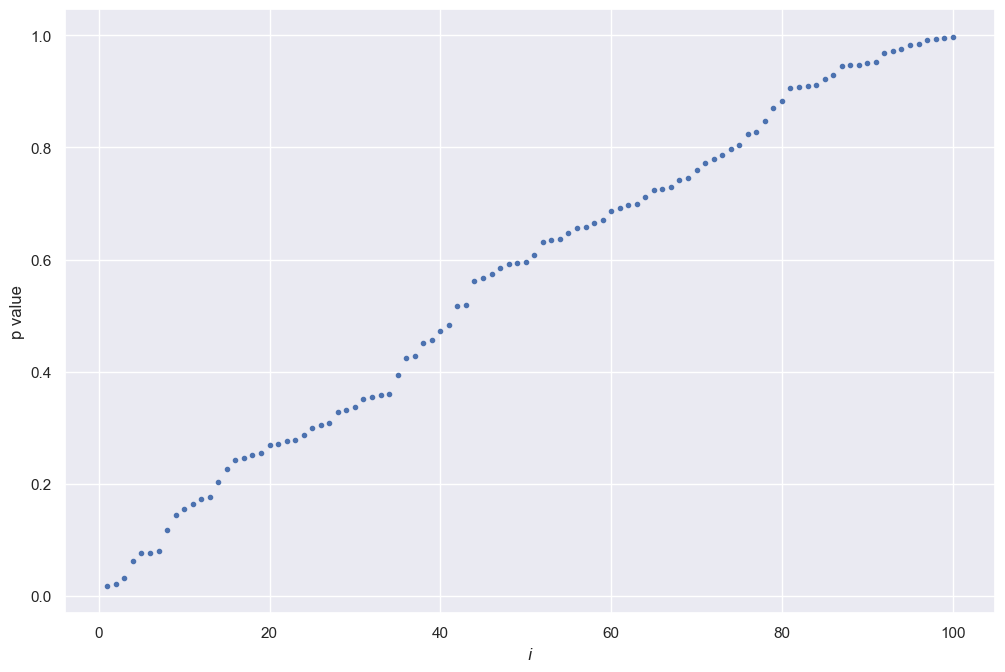

In [16]:
p_values = np.sort(p_values)

plt.figure(figsize=(12, 8), dpi=100)
i = np.arange(1, N + 1) # the 1-based i index of the p values, as in p(i)
plt.plot(i, p_values, '.')
plt.xlabel('$i$')
plt.ylabel('p value')
plt.show()

Мы хотим найти такой трешхолд $\theta(i)$, что только небольшая часть принятных гипотез будет ошибочно принята.

То есть мы хотим подобрать такое $\theta(i)$, что:

$$E(\mathrm{FalsePositive}) / \mathrm{chosen} < \alpha$$


$$
N \frac{p(i)}{i} < \alpha \implies p(i) < \alpha \frac{i}{N}
$$

Зафиксируем $\alpha=0.05$. Нарисуем $\alpha \frac{i}{N}$ (красная линия) вместе с $p(i)$ (синие точки):

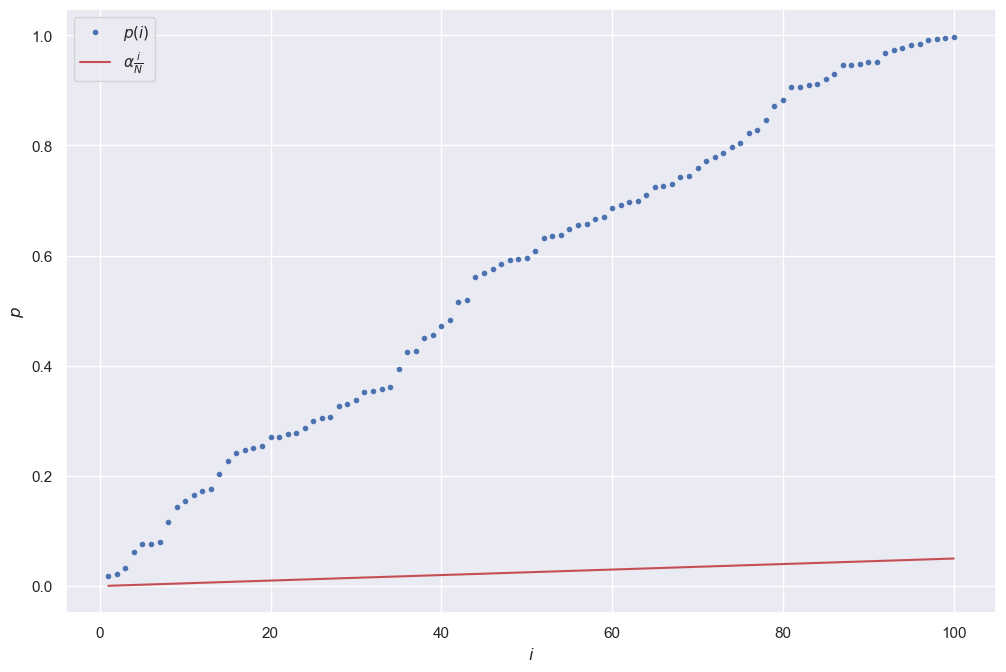

In [17]:
alpha = 0.05
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(i, p_values, 'b.', label='$p(i)$')
plt.plot(i, alpha * i / N, 'r', label=r'$\alpha \frac{i}{N}$')
plt.xlabel(r'$i$')
plt.ylabel(r'$p$')
plt.legend()
plt.show()

Теперь добавим шум в наши измерения.

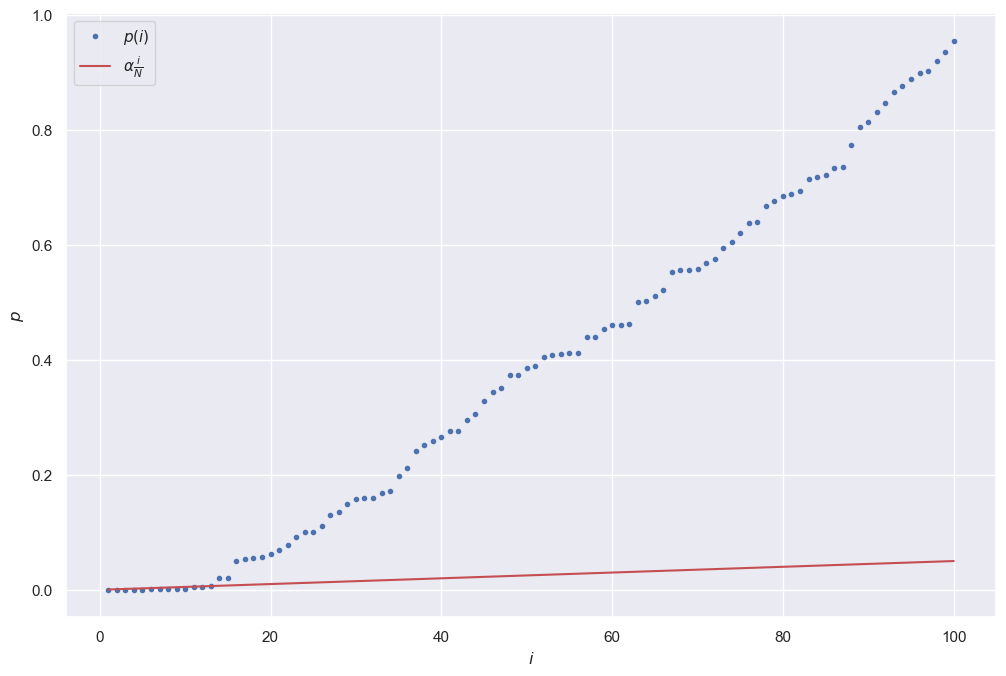

In [18]:
N_signal = 20
N_noise = N - N_signal
noise_z_values = np.random.normal(size=N_noise)
# Add some signal with very low z scores / p values

signal_z_values = np.random.normal(loc=-2.5, size=N_signal)
mixed_z_values = np.sort(np.concatenate((noise_z_values, signal_z_values)))
mixed_p_values = normal_distribution.cdf(mixed_z_values)
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(i, mixed_p_values, 'b.', label='$p(i)$')
plt.plot(i, alpha * i / N, 'r', label=r'$\alpha \frac{i}{N}$')
plt.xlabel('$i$')
plt.ylabel('$p$')
plt.legend()
plt.show()

Посмотрим поближе на начало графика:

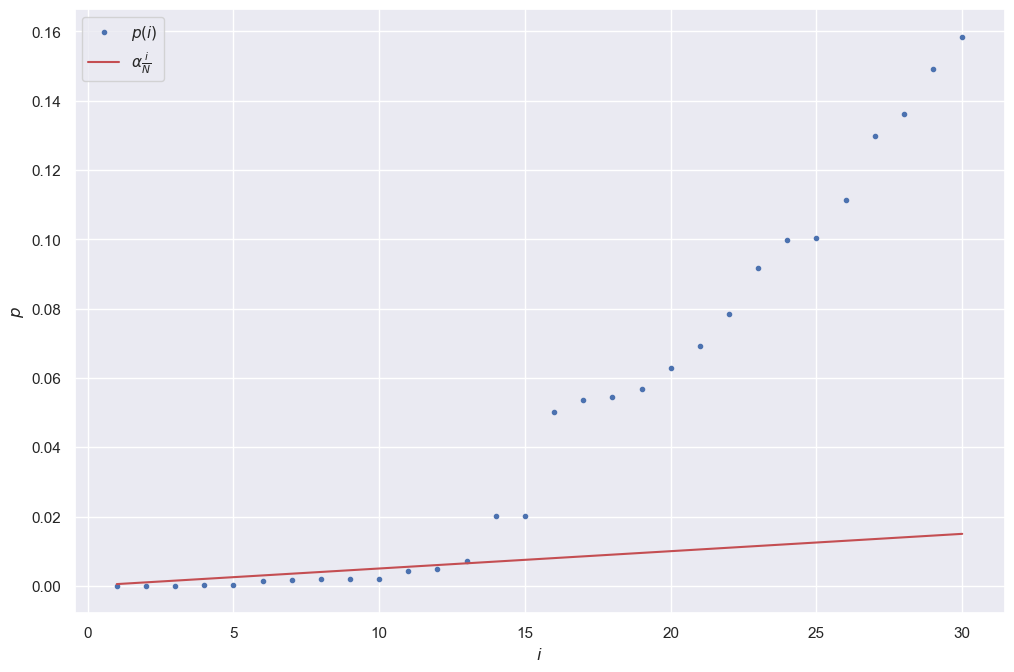

In [19]:
first_i = i[:30]
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(first_i, mixed_p_values[:30], 'b.', label='$p(i)$')
plt.plot(first_i, alpha * first_i / N, 'r', label=r'$\alpha \frac{i}{N}$')
plt.xlabel('$i$')
plt.ylabel('$p$')
plt.legend()

In [20]:
below = mixed_p_values < (alpha * i / N) # True where p(i)<alphai/N
max_below = np.max(np.where(below)[0]) # Max Python array index where p(i)<qi/N
print('p_i:', mixed_p_values[max_below])
print('i:', max_below + 1)

p_i: 0.004865271472510546
i: 12


# 3. Выбор лучшей модели машинного обучения

## Напишем свой собственный корректор с Бонферрони и FDR




In [21]:
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from collections import defaultdict
from tqdm import tqdm
from sklearn.feature_selection import f_regression, chi2
from statsmodels.stats import multitest
import warnings
warnings.filterwarnings("ignore")

https://www.kaggle.com/c/DrugActivityPrediction

```
The goal of this competition is to allow you to develop predictive models that can determine given a particular compound whether it is active (1) or not (0). As such, the goal would be develop the best binary classification model.

A molecule can be represented by 100000 binary features which represent their topological shapes and other characteristics important for binding.
```

In [22]:
#Read the input files and read every line
from tqdm import tqdm
def loadData(trainingFile):
    
    def convertDataframe(inputFile):
        data = pd.DataFrame(columns=range(100000))
        
        for i in tqdm(range(len(inputFile))):
            record = np.fromstring(inputFile[i], dtype=int, sep=' ')
            record_bool = [0 for j in range(100000)]
            for col in record:
                record_bool[col-1] = 1
            
            data.loc[i] = record_bool
            
        return data
    
    with open(trainingFile, "r") as fr1:
        trainFile = fr1.readlines()
    
    #Split each line in the two files into label and data  
    train_data_list = []
    train_labels_list = []
    
    for inputData in trainFile:
        train_labels_list.append(inputData[0])
        
        #Remove the activity label (0/1) and new line character from each record
        inputData = inputData.replace("0\t", "")
        inputData = inputData.replace("1\t", "")
        inputData = inputData.replace("\n", "")
        train_data_list.append(inputData)
    
    train_labels = np.asarray(train_labels_list)
    train_data = convertDataframe(train_data_list)  
            
    return train_data.values.astype(float), train_labels.astype(float)

In [23]:
X, y = loadData('./train.dat')

100%|██████████| 800/800 [03:14<00:00,  4.11it/s]


#### Мини-справка про распределение коэффициента корреляции

$$Cov(x, y) = \sum_i (x_i - \bar x) (y_i - \bar y)$$

$$corr(x, y) = \frac{Cov(x, y)}{\sigma_x \sigma_y}$$

$$(\textrm{len}(y) - 2)\frac{corr^2(x, y)}{1 - corr^2(x, y)} \sim F(1, \textrm{len}(y) - 2)$$

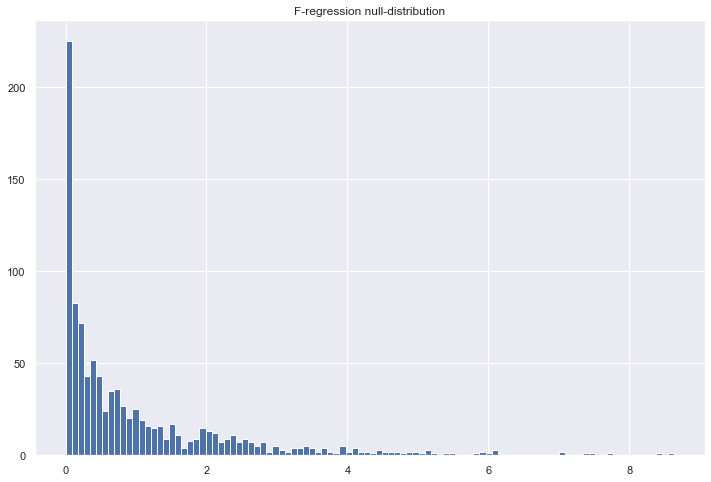

In [24]:
n_f = 100
corrs_f = []
for _ in range(1000):
    x_f = np.random.randn(n_f)
    y_f = np.random.randn(n_f)
    corr = np.corrcoef(x_f, y_f)[0, 1]
    corrs_f.append(corr)
corrs_f = np.array(corrs_f)
plt.figure(figsize=(12, 8))
plt.title('F-regression null-distribution')
plt.hist((n_f - 2) * corrs_f**2 / (1 - corrs_f**2), bins=100);
plt.show()

In [29]:
X.shape

(800, 100000)

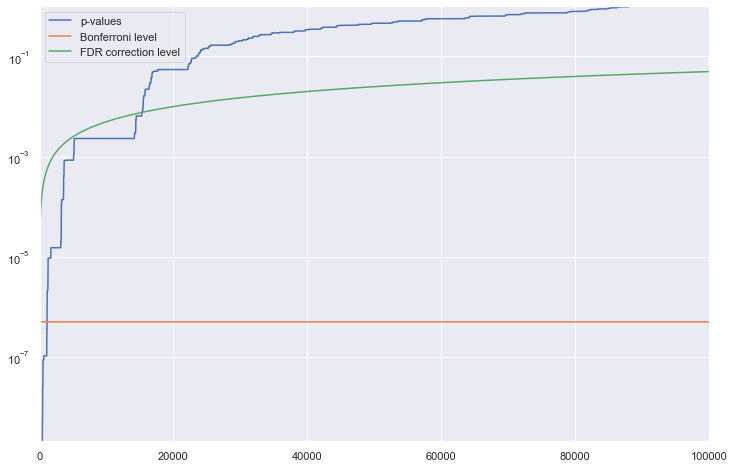

In [25]:
from sklearn.feature_selection import f_regression

_, pvals = f_regression(X=X, y=y)
alpha = 0.05

plt.figure(figsize=(12, 8))

plt.plot(np.arange(len(pvals)), np.sort(pvals), label='p-values')
plt.plot(np.arange(len(pvals)), len(pvals) * [alpha / len(pvals)], label='Bonferroni level')
plt.plot(np.arange(len(pvals)), np.arange(1, len(pvals) + 1) * alpha / len(pvals), label='FDR correction level')
plt.legend()
plt.yscale('log')
plt.xlim(0, 100000)
plt.ylim(np.exp(-20), np.exp(0))
plt.show()

In [30]:
class FTestCorrector:
    def __init__(self, alpha=0.1, method='bonferroni'):
        self.alpha = alpha
        self.mask = None
        self.method = method
        
    def fit(self, X, y):
        from sklearn.feature_selection import f_regression
        _, pvals = f_regression(X=X, y=y)
        if self.method == 'bonferroni':
            self.mask = pvals <= self.alpha / X.shape[1]
        elif self.method == 'fdr':
            self.mask, *_ = multitest.multipletests(pvals, alpha=self.alpha, method='fdr_bh')
        else:
            ValueError('No such method')
        return self
        
    def transform(self, X):
        return X[:, self.mask]

In [31]:
lr = LogisticRegression(solver='liblinear')

ftcorr = FTestCorrector(method='bonferroni', alpha=0.1)
pline = Pipeline([('ftest', ftcorr), ('lr', lr)])

In [32]:
cross_val_score(
    estimator=pline, X=X,
    y=y, cv=StratifiedKFold(n_splits=5, shuffle=True), 
    scoring="roc_auc").mean()

0.9206387092911879

In [33]:
ftcorr = FTestCorrector(method='fdr', alpha=0.1)
pline = Pipeline([('ftest', ftcorr), ('lr', lr)])

In [34]:
cross_val_score(
    estimator=pline, X=X,
    y=y, cv=StratifiedKFold(n_splits=5, shuffle=True), 
    scoring="roc_auc"
).mean()

0.9257359913793104

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings("ignore")

models = {
    'LogisticRegression': LogisticRegression(),
    'GaussianNB': GaussianNB(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'XGBClassifier': GradientBoostingClassifier()
}

In [36]:
# Будем классифицировать по отдельным людям и по 12 сессиям отдельно.
cv = 10
alpha = 0.01
methods = ['bonferroni', 'fdr']


scores = defaultdict(lambda: defaultdict(float))
for model in models:
    for method in methods:
        print("Processing %s %s" % (model, method))
        ftcorr = FTestCorrector(method=method, alpha=alpha)
        pline = Pipeline([('ftest', ftcorr), (model, models[model])])
        scores[model][method] = cross_val_score(estimator=pline, X=X,
                                                y=y, cv=StratifiedKFold(n_splits=cv, shuffle=True), scoring="roc_auc")

Processing LogisticRegression bonferroni
Processing LogisticRegression fdr
Processing GaussianNB bonferroni
Processing GaussianNB fdr
Processing KNeighborsClassifier bonferroni
Processing KNeighborsClassifier fdr
Processing XGBClassifier bonferroni
Processing XGBClassifier fdr


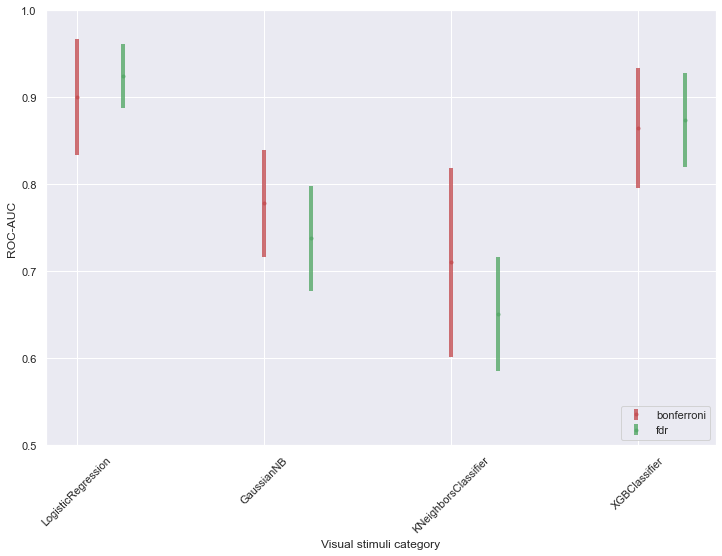

In [37]:
plt.figure(figsize=(12, 8))

tick_position = np.arange(len(models))
plt.xticks(tick_position, models.keys(), rotation=45)

for color, method in zip('rg', methods):
    score_means = [scores[model][method].mean() for model in models]
    score_stds = [scores[model][method].std() for model in models]
    plt.errorbar(tick_position, score_means, yerr=score_stds, fmt='.', lw=4, alpha=0.8, label=method, 
                 color=color)
    tick_position = tick_position + .25

plt.ylabel('ROC-AUC')
plt.xlabel('Visual stimuli category')
plt.ylim(0.5, 1.)
plt.legend(loc='lower right')
plt.show()